In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/Othercomputers/ThinkPad14/ai_motion_correction/*.py /content

Import custom libraries/functions

In [3]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 9.4 MB/s 


In [4]:
from network import VoxMorphAffine, AffineNeuralNetworkModel
from losses import NCC, similarity_loss, loss_for_matrix, regularizer_rot_matrix
from generators import  DataGenerator_train, DataGenerator_val
from ManageData4NN import ManageData4NN 

Import common libraries

In [5]:
import tensorflow as tf

import os, pickle, pydicom, time, math, json
import matplotlib.pyplot as plt
import numpy as np

In [6]:
datadir = '/content/drive/MyDrive/Colab Notebooks/ai_motion/data'
training_files = pickle.load(open(os.path.join(datadir,'dcm','dcm_colab_training_set.pkl'), 'rb'))
validation_files = pickle.load(open(os.path.join(datadir,'dcm','dcm_colab_validation_set.pkl'), 'rb'))

print('Training size:', len(training_files))
print('Validation size:', len(validation_files))

Training size: 810
Validation size: 202


Create the model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movable_input (InputLayer)     [(None, 128, 128, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 fixed_input (InputLayer)       [(None, 128, 128, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 input_pair (Concatenate)       (None, 128, 128, 12  0           ['fixed_input[0][0]',            
                                8, 2)                             'movable_input[0][0]']      

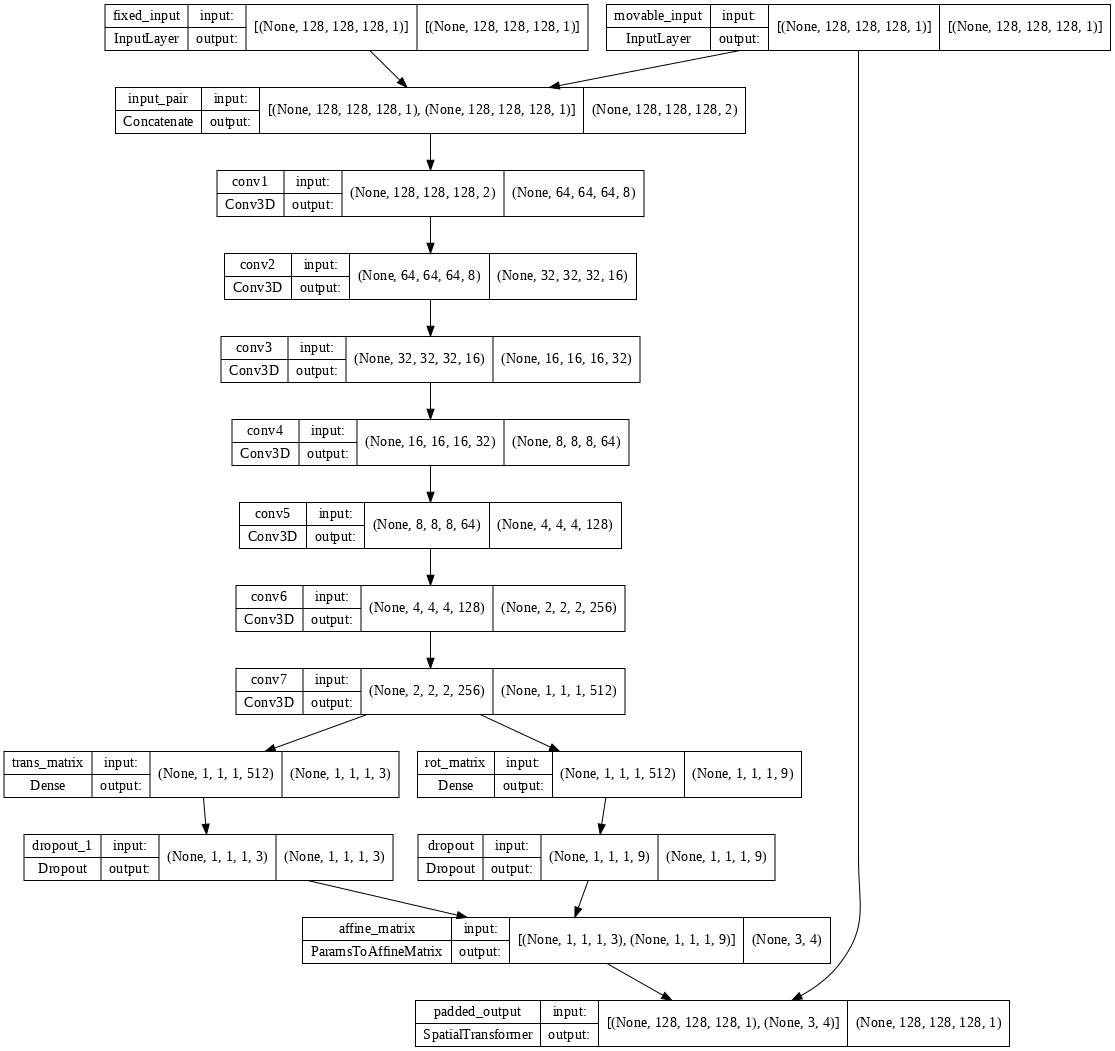

In [7]:
#affine_mdl = AffineNeuralNetworkModel()#ABIR()
affine_mdl = VoxMorphAffine()
print(affine_mdl.summary())
tf.keras.utils.plot_model(affine_mdl, show_shapes=True, show_layer_names=True, dpi=72)

Train the model

In [8]:
%load_ext tensorboard
!rm -rf ./logs/

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
   print('trans_mat:',tf.reduce_mean(affine_mdl.trainable_variables[14]))
   print('rot_mat:',tf.reduce_mean(affine_mdl.trainable_variables[15]))

mycallback = myCallback()

In [10]:
from keras.callbacks import TensorBoard, LearningRateScheduler,LambdaCallback
import datetime

#number of epochs
epochs = 30
#batch size
batch_size = 1


def step_decay(epoch):
	initial_lrate = 0.0001
	drop = 0.5
	epochs_drop = 5
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

lrate = LearningRateScheduler(step_decay)


adam = tf.keras.optimizers.Adam(0.0001)


print(step_decay(epochs))

mdl_check_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(datadir,'checkpoint_test'),
    monitor='val_loss',
    mode='min',
    save_best_only=True)


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


json_log = open('loss_log.json', mode='at', buffering=1)
json_logging_callback = LambdaCallback(
            on_epoch_end=lambda epoch, logs: json_log.write(
                json.dumps({'epoch': epoch, 
                            'loss': logs['loss'],
                            'rot_mat_weights': affine_mdl.layers[10].get_weights(),
                            'trans_mat_weights':affine_mdl.layers[11].get_weights()}) + '\n'),
            on_train_end=lambda logs: json_log.close()
)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                             update_freq='epoch', 
                                             write_images=True, write_grads=True)

tb_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)



affine_mdl.compile(loss={'padded_output':similarity_loss,#loss_class.loss,
                         'affine_matrix':regularizer_rot_matrix},
                   metrics = {'padded_output':tf.keras.metrics.MeanSquaredError(),
                              'affine_matrix':None},
                         optimizer=adam,
                          run_eagerly=True)

1.5625e-06


In [ ]:
%tensorboard --logdir logs/fit

#initialize the training generator
training_generator = DataGenerator_train(training_files, 
                                   batch_size=batch_size, 
                                   dim=(128, 128,128),
                                   n_channels=1, 
                                   shuffle=True)

#initialize the validation generator
validation_generator = DataGenerator_val(validation_files, 
                                   batch_size=batch_size, 
                                   dim=(128, 128,128),
                                   n_channels=1, 
                                   shuffle=True)

#fit the model
affine_mdl.fit(
    x = training_generator,
    validation_data = validation_generator, 
    epochs=epochs,
    callbacks=[tb_callback,mdl_check_callback,mycallback,lrate],
    verbose=2)

<IPython.core.display.Javascript object>

Epoch 1/30


trans_mat: tf.Tensor(-0.0038136477, shape=(), dtype=float32)
rot_mat: tf.Tensor(-0.007540723, shape=(), dtype=float32)
810/810 - 600s - loss: 0.2234 - padded_output_loss: 0.2171 - affine_matrix_loss: 0.0063 - padded_output_mean_squared_error: 0.0012 - val_loss: 0.0046 - val_padded_output_loss: 0.0042 - val_affine_matrix_loss: 4.5469e-04 - val_padded_output_mean_squared_error: 1.9890e-05 - lr: 1.0000e-04 - 600s/epoch - 741ms/step
Epoch 2/30
trans_mat: tf.Tensor(-0.003974395, shape=(), dtype=float32)
rot_mat: tf.Tensor(-0.005334055, shape=(), dtype=float32)
810/810 - 293s - loss: 0.2100 - padded_output_loss: 0.1988 - affine_matrix_loss: 0.0112 - padded_output_mean_squared_error: 0.0011 - val_loss: 0.0099 - val_padded_output_loss: 0.0095 - val_affine_matrix_loss: 4.0966e-04 - val_padded_output_mean_squared_error: 4.6136e-05 - lr: 1.0000e-04 - 293s/epoch - 361ms/step
Epoch 3/30


Save the model

In [ ]:
#save the results of the training
with open(os.path.join(datadir,'results','DCM_'+str(epochs)+'ep_'+str(batch_size)+'bs_VoxMorphAffine_NoAug_CC_tanh_dropout_history.csv'), 'wb') as f:
    pickle.dump(affine_mdl.history, f)

affine_mdl.save(os.path.join(datadir,'DCM_'+str(epochs)+'ep_'+str(batch_size)+'bs_VoxMorphAffine_tanh_dropout_NoAug_CC'))

Test the model on the testing dataset

In [ ]:
testing_files = pickle.load(open(os.path.join(datadir,'dcm','dcm_colab_testing_set.pkl'),'rb'))
print(testing_files)

[['/content/drive/MyDrive/Colab Notebooks/ai_motion/data/dcm/test/DCM/MicLuh_13062017_MREG_P02-0004-0001-00001.dcm', '/content/drive/MyDrive/Colab Notebooks/ai_motion/data/dcm/test/DCM/MicLuh_13062017_MREG_P02-0004-0001-00001.dcm'], ['/content/drive/MyDrive/Colab Notebooks/ai_motion/data/dcm/test/DCM/MicLuh_13062017_MREG_P02-0004-0002-00002.dcm', '/content/drive/MyDrive/Colab Notebooks/ai_motion/data/dcm/test/DCM/MicLuh_13062017_MREG_P02-0004-0001-00001.dcm'], ['/content/drive/MyDrive/Colab Notebooks/ai_motion/data/dcm/test/DCM/MicLuh_13062017_MREG_P02-0004-0003-00003.dcm', '/content/drive/MyDrive/Colab Notebooks/ai_motion/data/dcm/test/DCM/MicLuh_13062017_MREG_P02-0004-0001-00001.dcm'], ['/content/drive/MyDrive/Colab Notebooks/ai_motion/data/dcm/test/DCM/MicLuh_13062017_MREG_P02-0004-0004-00004.dcm', '/content/drive/MyDrive/Colab Notebooks/ai_motion/data/dcm/test/DCM/MicLuh_13062017_MREG_P02-0004-0001-00001.dcm'], ['/content/drive/MyDrive/Colab Notebooks/ai_motion/data/dcm/test/DCM/Mi

In [ ]:
#affine_mdl2 = tf.keras.models.load_model(os.path.join(datadir,'DCM_'+str(epochs)+'ep_'+str(batch_size)+'bs_VoxMorph_Aug_NCC'), 
#                                        custom_objects={'similarity_loss':loss_class.loss, 
#                                                        'voxmorph_loss_for_matrix':voxmorph_loss_for_matrix})

affine_mdl2 = tf.keras.models.load_model(os.path.join(datadir,'checkpoint_test'),compile=False)

In [ ]:
dcm_outdir = os.path.join(datadir,'results','aligned_dcm')

#create an instance of the DataManager
testing_data_mgr = ManageData4NN()
#variable to list all the motion params
all_motion = []
for idx, testing_pair in enumerate(testing_files):
    testing_data_mgr.generate_target(pydicom.dcmread(testing_pair[1]))
    targ_input = testing_data_mgr.get_target()
    #movable for NN
    mov_dcm_file = pydicom.dcmread(testing_pair[0])
    mov_input = testing_data_mgr.generate_movable(mov_dcm_file)
    #launch the model prediction
    
    #output,W,b = affine_mdl2.predict([targ_input,testing_data_mgr.movable])

    #interp_output, motion = testing_data_mgr.process_otput(testing_data_mgr.get_orig_movable(),
#                                                          W,
#                                                          b)



    output,affine_matrix = affine_mdl2.predict([targ_input,testing_data_mgr.movable])
    #print(affine_matrix)

    interp_output, motion = testing_data_mgr.process_output_voxmorph(affine_matrix,
                                                          mov_dcm_file, 
                                                          dcm_outdir, 
                                                          idx)
    
    all_motion.append(motion)
    #print('Elapsed time:',time.time()-start)

In [ ]:
affine_matrix

array([[[ 1.0018275e+00, -2.1092674e-05, -4.0881168e-03, -9.3022637e-02],
        [ 3.0328403e-03,  1.0049274e+00,  2.4469988e-03,  1.3706456e-01],
        [ 1.2641095e-02,  6.7995191e-03,  9.9663270e-01, -6.9702759e-02]]],
      dtype=float32)

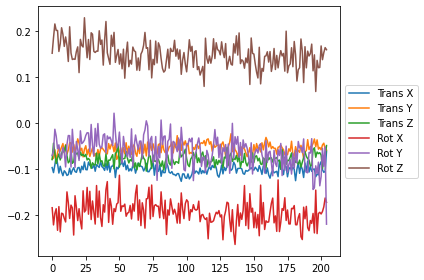

In [ ]:
f, ax = plt.subplots()
ax.plot(np.array(all_motion))
legend_labels = ['Trans X', 'Trans Y', 'Trans Z', 'Rot X', 'Rot Y', 'Rot Z']
ax.legend(labels = legend_labels,loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(datadir,'results','motion_params_bias_tanh_dropout.png'),dpi=300)

Diff aligned-target: 191103.82907916972
Diff movable-target: 64432.0


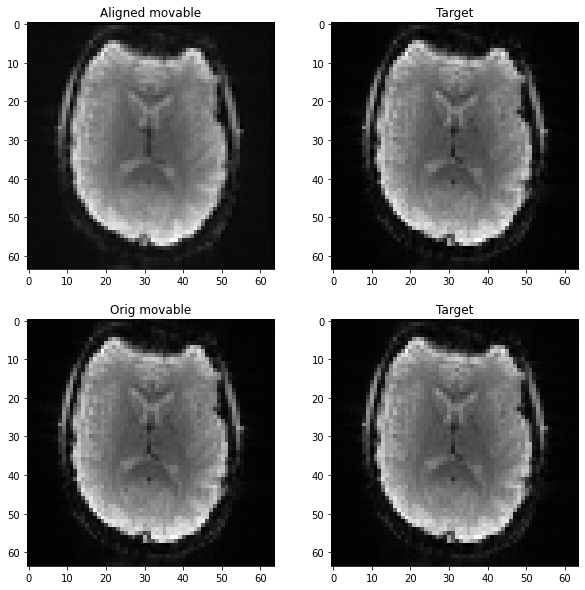

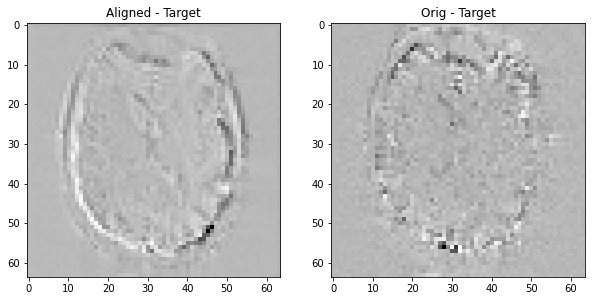

In [ ]:
orig_target = testing_data_mgr.mosaic_to_mat(pydicom.dcmread(testing_pair[1]))


fig,ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].imshow(interp_output[:,:,20], cmap='Greys_r', interpolation=None)
ax[0,0].set_title('Aligned movable')
ax[0,1].imshow(orig_target[:,:,20], cmap='Greys_r', interpolation=None)
ax[0,1].set_title('Target')

ax[1,0].imshow(testing_data_mgr.get_orig_movable()[:,:,20], cmap='Greys_r', interpolation=None)
ax[1,0].set_title('Orig movable')
ax[1,1].imshow(orig_target[:,:,20], cmap='Greys_r', interpolation=None)
ax[1,1].set_title('Target')

fig2, ax2 = plt.subplots(1,2, figsize=(10,10))
ax2[0].imshow(interp_output[:,:,20]-orig_target[:,:,20],cmap='Greys_r')
ax2[0].set_title('Aligned - Target')
#plt.colorbar(interp_output[:,:,32]-orig_target[:,:,32], ax= ax2[0])
ax2[1].imshow(testing_data_mgr.get_orig_movable()[:,:,20]-orig_target[:,:,20],cmap='Greys_r')
ax2[1].set_title('Orig - Target')
#plt.colorbar(testing_data_mgr.get_orig_movable()[:,:,32]-orig_target[:,:,32], ax= ax2[1])
#fig2.colorbar(interp_output[:,:,32]-orig_target[:,:,32])

plt.savefig(os.path.join(datadir,'results','slide20_bias_tanh.png'),dpi=300)

print('Diff aligned-target:', abs(np.sum(interp_output[:,:,16]-orig_target[:,:,16])))
print('Diff movable-target:', abs(np.sum(testing_data_mgr.get_orig_movable()[:,:,16]-orig_target[:,:,16])))

In [ ]:
all_motion[0]

array([-0.04801831,  0.0399576 ,  0.01233631,  0.12434173, -0.31097988,
       -0.18800845])

In [ ]:
tensorboard dev list

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 308, in run
    _run_main(

In [ ]:
!tensorboard dev upload --logdir ./logs \
  --name "CC_ep30_bs1_bias_tanh_dropout" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=ZA44DQ0mxJghhCx7T5HkdFx9ahwUAD&prompt=consent&access_type=offline
Enter 